In [3]:
import pandas
import matplotlib as plt
%matplotlib inline
import csv
import seaborn as sls
import numpy as np
from scipy.stats import kendalltau
from time import time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn.metrics import accuracy_score

def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [4]:
train_set = pandas.read_csv("train.csv")
train_set

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_set = train_set[train_set.pixel153 == 0.0]
test_set.to_csv('test_save.csv')

Имеем в тестовой выборке 41999 экземпляра для обучения, каждый из которых имеет по 785 параметров, где label - цифра, pixel0 - pixel783 значения соответсвующих пикселей в картинке.

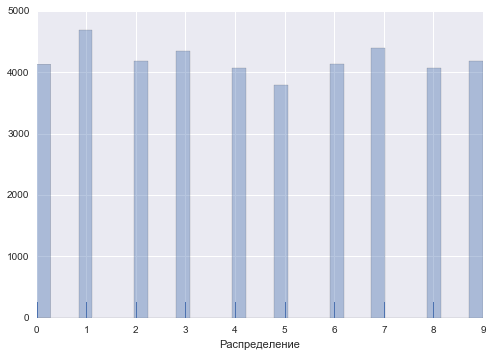

In [5]:
graph = sls.distplot(train_set['label'],kde=False, rug=True)
graph.set(xlabel = 'Распределение')
graph

In [6]:
print(train_set['label'].describe())
print()
for i in range(10):
    print('we have', train_set[train_set.label == i].size // 785, 'of', i, 'images')

count    42000.000000
mean         4.456643
std          2.887730
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: label, dtype: float64

we have 4132 of 0 images
we have 4684 of 1 images
we have 4177 of 2 images
we have 4351 of 3 images
we have 4072 of 4 images
we have 3795 of 5 images
we have 4137 of 6 images
we have 4401 of 7 images
we have 4063 of 8 images
we have 4188 of 9 images


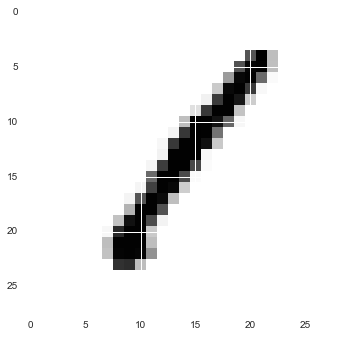

In [5]:
frame = train_set[:1]

def convert(frame):
    return frame.iloc[:,1:].values

def show_pic(img):
    img = img.reshape(28,28)
    plt.pyplot.imshow(img, interpolation='nearest')

show_pic(convert(frame))

def save_pic(img):
    plt.pyplot.savefig('img.jpg')

save_pic(convert(frame))

Средняя картинка попиксельно

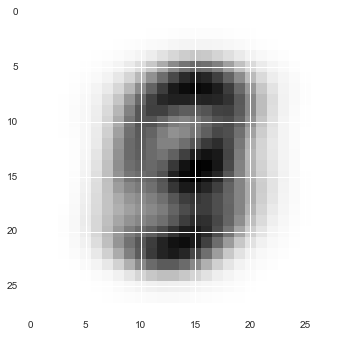

In [8]:
def deep_copy(self):
    return pandas.DataFrame(self.values.copy(), self.index.copy(), self.columns.copy())

mean_pic_pixel = deep_copy(train_set[:1])

for i in range(784):
    mean_pic_pixel['pixel' + str(i)] = int(train_set['pixel' + str(i)].mean())
show_pic(convert(mean_pic_pixel))

Средние картинки для каждого класса

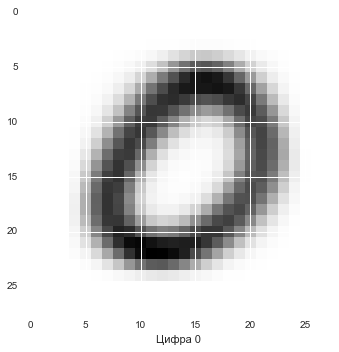

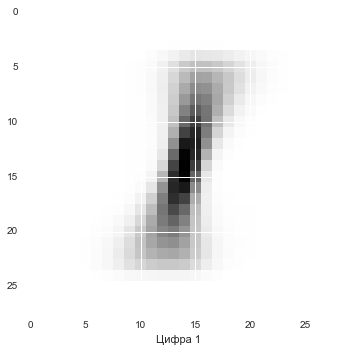

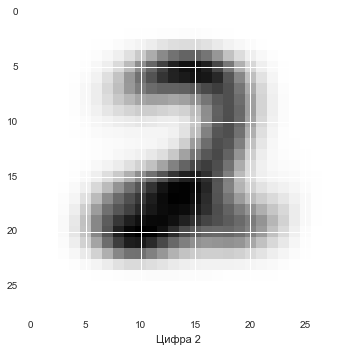

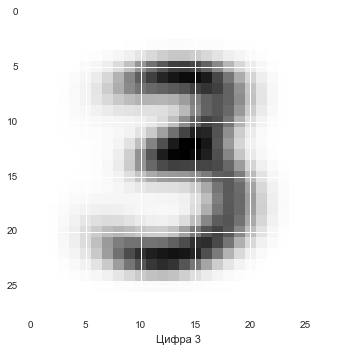

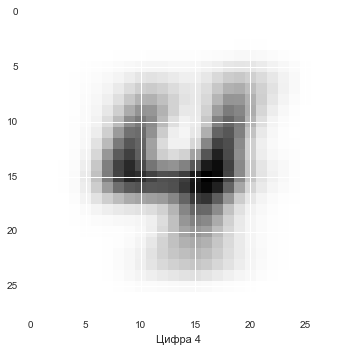

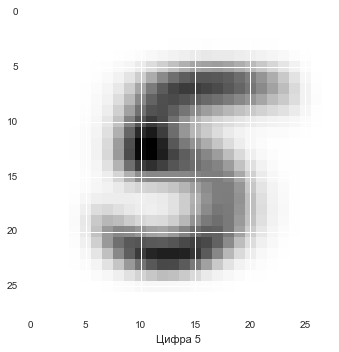

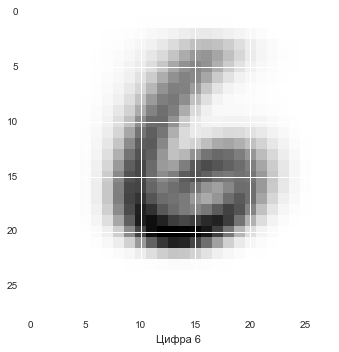

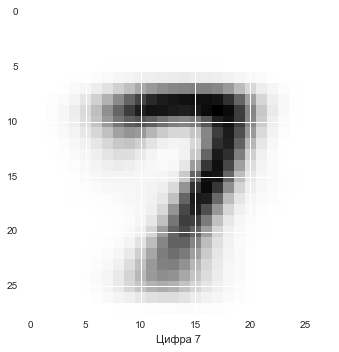

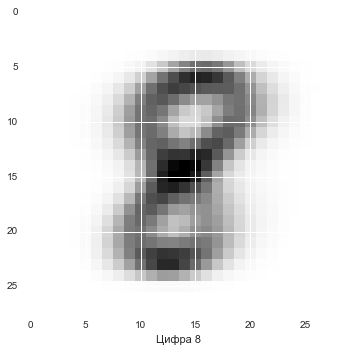

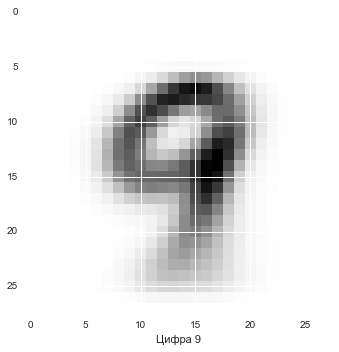

In [10]:
mean_pics = []
for i in range(10):
    mean_pics.append(deep_copy(train_set[:1]))
    
for j in range(10):
    tempset = train_set[train_set.label == j]
    for i in range(784):
        mean_pics[j]['pixel' + str(i)] = int(tempset['pixel' + str(i)].mean())
    fig = plt.pyplot.figure()
    show_pic(convert(mean_pics[j]))
    plt.pyplot.xlabel('Цифра ' + str(j))

Среднеквадратичная картинка по всей выборке

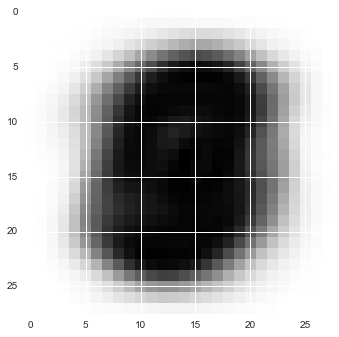

In [11]:
mean_sqr_pic_pixel = deep_copy(train_set[:1])

for i in range(784):
    mean = int(train_set['pixel' + str(i)].mean())
    ans = 0
    for elem in train_set['pixel' + str(i)]:
        ans += (mean - elem) ** 2
    ans /= len(train_set['pixel' + str(i)])
    ans = ans ** 0.5
    mean_sqr_pic_pixel['pixel' + str(i)] = ans
show_pic(convert(mean_sqr_pic_pixel))

Среднеквадратичные картинки по каждому классу

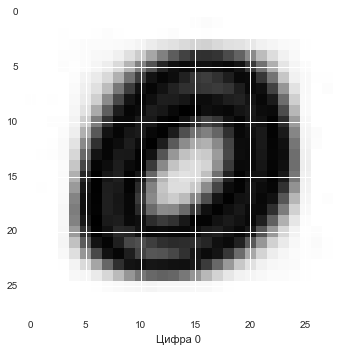

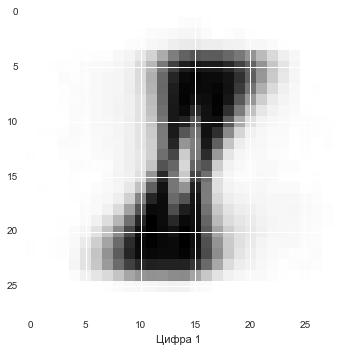

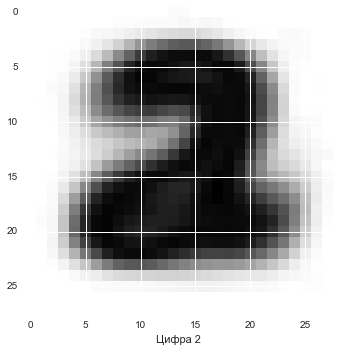

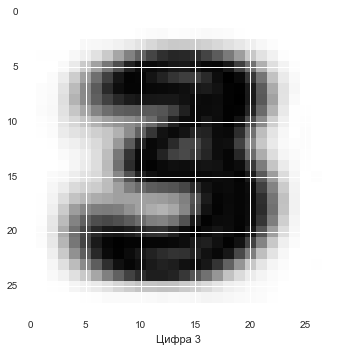

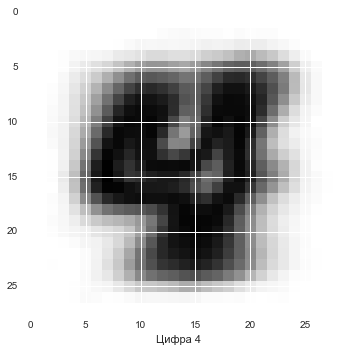

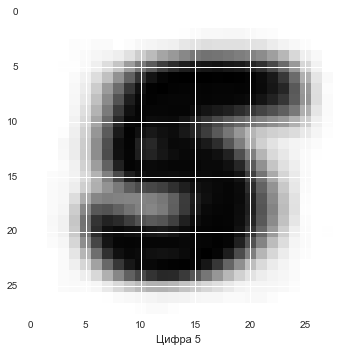

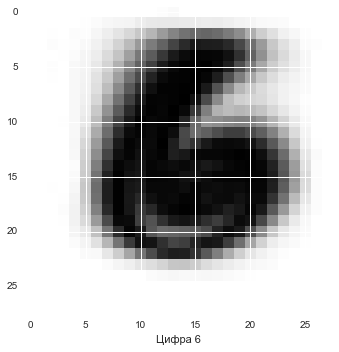

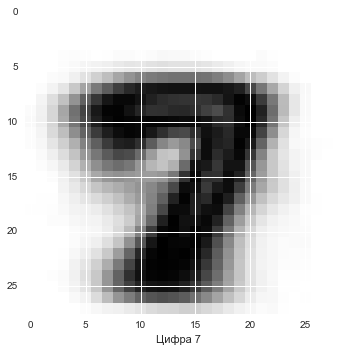

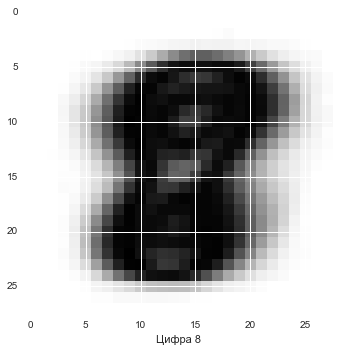

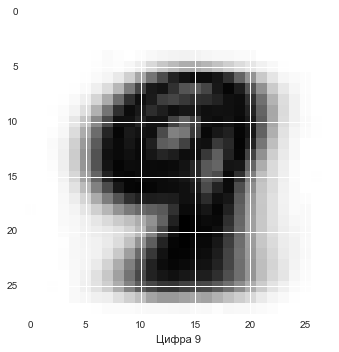

In [12]:
mean_sqr_pics = []
for i in range(10):
    mean_sqr_pics.append(deep_copy(train_set[:1]))
    
for j in range(10):
    tempset = train_set[train_set.label == j]
    for i in range(784):
        mean = int(tempset['pixel' + str(i)].mean())
        ans = 0
        for elem in tempset['pixel' + str(i)]:
            ans += (mean - elem) ** 2
        ans /= len(tempset['pixel' + str(i)])
        ans = ans ** 0.5
        mean_sqr_pics[j]['pixel' + str(i)] = ans
    fig = plt.pyplot.figure()
    show_pic(convert(mean_sqr_pics[j]))
    plt.pyplot.xlabel('Цифра ' + str(j))

Попробуем отранжировать пиксели по их значимости

In [33]:
white_pixel_stats = []
for row in train_set.columns[1:]:
    white_pixel_stats.append(len(train_set[train_set[row] == 0]))
black_pixel_stats = []
for row in train_set.columns[1:]:
    black_pixel_stats.append(len(train_set[train_set[row] == 255]))

In [34]:
pandas.DataFrame(white_pixel_stats).describe()

,0
count,784.000000
mean,33955.755102
std,9781.264152
min,11549.000000
25%,25164.500000
50%,39745.000000
75%,41951.250000
max,42000.000000


In [35]:
pandas.DataFrame(black_pixel_stats).describe()

,0
count,784.000000
mean,284.834184
std,378.719781
min,0.000000
25%,1.000000
50%,62.000000
75%,574.000000
max,1892.000000


Попробуем классификаторы для ранжирования пикселей

In [15]:
y = train_set.label
x = []
for i in range(42000):
    x.append(list(convert(train_set[i:i + 1])[0]))

In [62]:
n_jobs = -1

print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

t0 = time()

forest = ExtraTreesClassifier(n_estimators=2000,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2, random_state=0)

forest.fit(X_train, y_train)

y_predict = forest.predict(X_test)

print('we have ', accuracy_score(y_test, y_predict), 'of accuracy on ExtraTreeClassifier')

print("done in %0.3fs" % (time() - t0))

importances = forest.feature_importances_

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.971547619048 of accuracy on ExtraTreeClassifier
done in 497.239s


И так, имеем топ 15 в порядке убывания пикселей:

In [67]:
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(np.array(x).shape[1])[:15]:
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 378 (0.016453)
2. feature 350 (0.015496)
3. feature 461 (0.009529)
4. feature 211 (0.009148)
5. feature 489 (0.008974)
6. feature 409 (0.008961)
7. feature 542 (0.008364)
8. feature 406 (0.008251)
9. feature 462 (0.007785)
10. feature 514 (0.007740)
11. feature 433 (0.007735)
12. feature 155 (0.007684)
13. feature 210 (0.007522)
14. feature 375 (0.007499)
15. feature 347 (0.007446)
